# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../logs/comick/79_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))
oov_embeddings = {key: np.zeros((64), dtype=np.float32) for key, _ in oov_embeddings.items()}

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5019 | MulticlassF1Score=0.1342
Batch-30 : CrossEntropyLoss=2.4659 | MulticlassF1Score=0.2091
Batch-45 : CrossEntropyLoss=2.4210 | MulticlassF1Score=0.2686
Batch-60 : CrossEntropyLoss=2.3841 | MulticlassF1Score=0.3190
Batch-75 : CrossEntropyLoss=2.3892 | MulticlassF1Score=0.3661
Batch-90 : CrossEntropyLoss=2.3849 | MulticlassF1Score=0.3981
Batch-105: CrossEntropyLoss=2.3669 | MulticlassF1Score=0.4243
Batch-120: CrossEntropyLoss=2.3652 | MulticlassF1Score=0.4499
Batch-135: CrossEntropyLoss=2.3445 | MulticlassF1Score=0.4708
Batch-150: CrossEntropyLoss=2.3589 | MulticlassF1Score=0.4880
Batch-165: CrossEntropyLoss=2.3560 | MulticlassF1Score=0.5030
Batch-180: CrossEntropyLoss=2.3614 | MulticlassF1Score=0.5144
Batch-195: CrossEntropyLoss=2.3366 | MulticlassF1Score=0.5273
Batch-210: CrossEntropyLoss=2.3516 | MulticlassF1Score=0.5390
Batch-225: CrossEntropyLoss=2.3332 | MulticlassF1Score=0.5500
Batch-226: CrossEntropyLoss=2.3422 | MulticlassF1Score=0.5505

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3290 | MulticlassF1Score=0.7032
Batch-30 : CrossEntropyLoss=2.3349 | MulticlassF1Score=0.7053
Batch-45 : CrossEntropyLoss=2.3355 | MulticlassF1Score=0.7071
Batch-60 : CrossEntropyLoss=2.3448 | MulticlassF1Score=0.7065
Batch-63 : CrossEntropyLoss=2.3670 | MulticlassF1Score=0.7062

Training   : Mean CrossEntropyLoss = 2.3981 | Mean MulticlassF1Score = 0.3945
Validation : Mean CrossEntropyLoss = 2.3413 | Mean MulticlassF1Score = 0.7041

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3188 | MulticlassF1Score=0.7304
Batch-30 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7404
Batch-45 : CrossEntropyLoss=2.3315 | MulticlassF1Score=0.7442
Batch-60 : CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7483
Batch-75 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7526
Batch-90 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7560
Batch-105: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7574
Batch-120: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7587
Batch-135: CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7592
Batch-150: CrossEntropyLoss=2.3231 | MulticlassF1Score=0.7600
Batch-165: CrossEntropyLoss=2.3285 | MulticlassF1Score=0.7607
Batch-180: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7617
Batch-195: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7619
Batch-210: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7624
Batch-225: CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7635
Batch-226: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7635

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7629
Batch-30 : CrossEntropyLoss=2.3233 | MulticlassF1Score=0.7656
Batch-45 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7658
Batch-60 : CrossEntropyLoss=2.3237 | MulticlassF1Score=0.7664
Batch-63 : CrossEntropyLoss=2.3208 | MulticlassF1Score=0.7665

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3220 | Mean MulticlassF1Score = 0.7529
Validation : Mean CrossEntropyLoss = 2.3201 | Mean MulticlassF1Score = 0.7659

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7697
Batch-30 : CrossEntropyLoss=2.3276 | MulticlassF1Score=0.7667
Batch-45 : CrossEntropyLoss=2.3271 | MulticlassF1Score=0.7684
Batch-60 : CrossEntropyLoss=2.3208 | MulticlassF1Score=0.7693
Batch-75 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7701
Batch-90 : CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7698
Batch-105: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7705
Batch-120: CrossEntropyLoss=2.3259 | MulticlassF1Score=0.7707
Batch-135: CrossEntropyLoss=2.3292 | MulticlassF1Score=0.7709
Batch-150: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.7723
Batch-165: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7741
Batch-180: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7757
Batch-195: CrossEntropyLoss=2.3216 | MulticlassF1Score=0.7771
Batch-210: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7783
Batch-225: CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7796
Batch-226: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.7796

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7866
Batch-30 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7876
Batch-45 : CrossEntropyLoss=2.3219 | MulticlassF1Score=0.7895
Batch-60 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7896
Batch-63 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7896

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3163 | Mean MulticlassF1Score = 0.7719
Validation : Mean CrossEntropyLoss = 2.3126 | Mean MulticlassF1Score = 0.7886

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8043
Batch-30 : CrossEntropyLoss=2.3176 | MulticlassF1Score=0.8028
Batch-45 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8032
Batch-60 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8019
Batch-75 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8026
Batch-90 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.8034
Batch-105: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.8035
Batch-120: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.8031
Batch-135: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.8033
Batch-150: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8040
Batch-165: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8044
Batch-180: CrossEntropyLoss=2.3202 | MulticlassF1Score=0.8039
Batch-195: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8038
Batch-210: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.8036
Batch-225: CrossEntropyLoss=2.3165 | MulticlassF1Score=0.8034
Batch-226: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.8034

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8024
Batch-30 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8001
Batch-45 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7993
Batch-60 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8010
Batch-63 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8006

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3088 | Mean MulticlassF1Score = 0.8036
Validation : Mean CrossEntropyLoss = 2.3091 | Mean MulticlassF1Score = 0.7996

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8140
Batch-30 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8123
Batch-45 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8155
Batch-60 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8165
Batch-75 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8176
Batch-90 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8182
Batch-105: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8192
Batch-120: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8197
Batch-135: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8204
Batch-150: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8210
Batch-165: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8219
Batch-180: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8217
Batch-195: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8220
Batch-210: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8222
Batch-225: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8225
Batch-226: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8225

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8214
Batch-30 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8224
Batch-45 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8213
Batch-60 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8213
Batch-63 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3030 | Mean MulticlassF1Score = 0.8185
Validation : Mean CrossEntropyLoss = 2.3029 | Mean MulticlassF1Score = 0.8217

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8331
Batch-30 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8325
Batch-45 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8312
Batch-60 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8312
Batch-75 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8313
Batch-90 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8312
Batch-105: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8316
Batch-120: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8317
Batch-135: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8312
Batch-150: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8313
Batch-165: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8312
Batch-180: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8305
Batch-195: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8303
Batch-210: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8298
Batch-225: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8297
Batch-226: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8298

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8239
Batch-30 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8249
Batch-45 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8242
Batch-60 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8238
Batch-63 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8316
Validation : Mean CrossEntropyLoss = 2.3021 | Mean MulticlassF1Score = 0.8233

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8279
Batch-30 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8296
Batch-45 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8281
Batch-60 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8272
Batch-75 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8282
Batch-90 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8293
Batch-105: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8303
Batch-120: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8304
Batch-135: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8311
Batch-150: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8327
Batch-165: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8343
Batch-180: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8360
Batch-195: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8372
Batch-210: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8383
Batch-225: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8388
Batch-226: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8388

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8438
Batch-30 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8366
Batch-45 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8392
Batch-60 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8406
Batch-63 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8405

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2978 | Mean MulticlassF1Score = 0.8315
Validation : Mean CrossEntropyLoss = 2.2970 | Mean MulticlassF1Score = 0.8402

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8504
Batch-30 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8511
Batch-45 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8516
Batch-60 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8518
Batch-75 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8505
Batch-90 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8501
Batch-105: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8497
Batch-120: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8505
Batch-135: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8502
Batch-150: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8506
Batch-165: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8503
Batch-180: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8501
Batch-195: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8504
Batch-210: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8504
Batch-225: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8503
Batch-226: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8504

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8515
Batch-30 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8459
Batch-45 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8436
Batch-60 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8442
Batch-63 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8445

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2942 | Mean MulticlassF1Score = 0.8508
Validation : Mean CrossEntropyLoss = 2.2957 | Mean MulticlassF1Score = 0.8470

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8670
Batch-30 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8702
Batch-45 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8730
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8744
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8756
Batch-90 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8771
Batch-105: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8770
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8771
Batch-135: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8771
Batch-150: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8768
Batch-165: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8767
Batch-180: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8768
Batch-195: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8769
Batch-210: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8771
Batch-225: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8770
Batch-226: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8769

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8723
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8708
Batch-45 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8700
Batch-60 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8704
Batch-63 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8708

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2861 | Mean MulticlassF1Score = 0.8746
Validation : Mean CrossEntropyLoss = 2.2878 | Mean MulticlassF1Score = 0.8713

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8809
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8800
Batch-45 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8791
Batch-60 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8793
Batch-75 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8807
Batch-90 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8814
Batch-105: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8817
Batch-120: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8822
Batch-135: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8823
Batch-150: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8822
Batch-165: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8823
Batch-180: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8826
Batch-195: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8825
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8826
Batch-225: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8834
Batch-226: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8835

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8961
Batch-30 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8938
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8927
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8926
Batch-63 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8931

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8815
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8936

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9079
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9113
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9097
Batch-75 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9076
Batch-90 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9077
Batch-105: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9073
Batch-120: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9079
Batch-135: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9075
Batch-150: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.9080
Batch-165: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9081
Batch-180: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9076
Batch-195: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9081
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9081
Batch-225: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9084
Batch-226: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9084

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9034
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9019
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9001
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8998
Batch-63 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8997

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2763 | Mean MulticlassF1Score = 0.9083
Validation : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.9009

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9129
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9163
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9149
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9150
Batch-75 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9150
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9141
Batch-105: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9145
Batch-120: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9145
Batch-135: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9141
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9143
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9149
Batch-180: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9153
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9156
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9156
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9156
Batch-226: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9156

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9065
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9041
Batch-45 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9037
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9024
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9024

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9150
Validation : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9052

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9181
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9178
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9185
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9183
Batch-105: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9184
Batch-120: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9180
Batch-135: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9174
Batch-150: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9175
Batch-165: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9174
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9173
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9175
Batch-210: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9179
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9182
Batch-226: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9181

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9011
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9036
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9056
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9053
Batch-63 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.9046

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9181
Validation : Mean CrossEntropyLoss = 2.2772 | Mean MulticlassF1Score = 0.9043

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9209
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9201
Batch-75 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9204
Batch-90 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9196
Batch-105: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9195
Batch-120: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9193
Batch-135: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9197
Batch-150: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9197
Batch-165: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9198
Batch-180: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9200
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9202
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9204
Batch-225: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9203
Batch-226: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9204

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9080
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9032
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9034
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9053
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9050

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9203
Validation : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9050

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9249
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9241
Batch-90 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9232
Batch-105: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9230
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9231
Batch-135: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9225
Batch-150: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9224
Batch-165: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9226
Batch-180: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9231
Batch-195: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9227
Batch-210: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9220
Batch-225: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9220
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9220

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9031
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9047
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9047
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9051
Batch-63 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9048

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9233
Validation : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9038

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9238
Batch-75 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9255
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9254
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9252
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9261
Batch-135: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9260
Batch-150: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9255
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9255
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9256
Batch-195: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9256
Batch-210: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9255
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9257
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9258

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9075
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9107
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9096
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9094
Batch-63 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9092

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9252
Validation : Mean CrossEntropyLoss = 2.2756 | Mean MulticlassF1Score = 0.9084

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9276
Batch-75 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9278
Batch-90 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9275
Batch-105: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9279
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9282
Batch-135: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9280
Batch-150: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9279
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9281
Batch-180: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9284
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9284
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9283
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9281
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9282

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9110
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9100
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9102
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9110

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9276
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9102

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9270
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9282
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9299
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9315
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9311
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9312
Batch-105: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9305
Batch-120: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9309
Batch-135: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9301
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9302
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9302
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9303
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9301
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9300
Batch-225: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9302
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9302

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9083
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9093
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9115
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9109
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9111

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9302
Validation : Mean CrossEntropyLoss = 2.2751 | Mean MulticlassF1Score = 0.9096

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9342
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9303
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9301
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9308
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9308
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9312
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9311
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9320
Batch-150: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9319
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9318
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9317
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9317
Batch-210: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9317
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9318
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9318

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9158
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9131
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9123
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9115
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9115

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9314
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9127

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9347
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9333
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9329
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9330
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9332
Batch-90 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9331
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9336
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9341
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9339
Batch-150: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9338
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9339
Batch-180: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9343
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9342
Batch-210: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9341
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9343
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9343

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9140
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9135
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9336
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9133

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9377
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9365
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9364
Batch-90 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9363
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9363
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9364
Batch-150: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9359
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9363
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9365
Batch-195: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9360
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9359
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9362
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9362

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9136
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9136
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9133
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9141

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9365
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9132

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9377
Batch-75 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9376
Batch-90 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9370
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9366
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9369
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9367
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9367
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9367
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9367
Batch-210: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9369
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9136
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9127
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9136
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9143
Batch-63 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.9141

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9374
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9138

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9379
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9384
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9377
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9376
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9376
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9373
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9375
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9376
Batch-165: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9374
Batch-180: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9372
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9376
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9375
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9376
Batch-226: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9375

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9131
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9140
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9136
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9140
Batch-63 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9380
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9140

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9385
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9382
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9380
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9377
Batch-135: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9373
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9375
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9378
Batch-180: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9377
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9375
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9157
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9129
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9138
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9134
Batch-63 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9383
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9148

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9372
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9403
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9396
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9376
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9385
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9383
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9383
Batch-165: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9384
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9383
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9381
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9380
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9380

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9124
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9120
Batch-60 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9135

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9386
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9139

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9404
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9411
Batch-75 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9398
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9393
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9390
Batch-135: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9390
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9387
Batch-195: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9384
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9383
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9381
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9381

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9111
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9127
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9129
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9128
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9130

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9394
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9124
Patience = 1/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9402
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9403
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9389
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9390
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9388
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9385
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9385
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9384
Batch-226: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9383

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9150
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9135
Batch-63 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9399
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9146

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9387
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9389
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9392
Batch-90 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9392
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9394
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9396
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9392
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9391
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9407
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9428

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9320
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9312
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9320
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9325
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9329

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9395
Validation : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9308

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9595
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9584
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9590
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9583
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9590
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9595
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9591
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9591
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9592
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9590
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9593
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9591
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9586
Batch-210: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9586
Batch-225: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9587
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9587

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9325
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9316
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9328
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9328

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9588
Validation : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9329

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9588
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9613
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9605
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9602
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9603
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9601
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9598
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9592
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9591
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9593
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9594
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9590
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9588
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9587
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9589
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9589

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9337
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9315
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9327
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9324
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9326

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9596
Validation : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9335

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9593
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9606
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9602
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9607
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9601
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9595
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9593
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9598
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9598
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9601
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9597
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9597
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9592
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9592
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9592
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9592

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9360
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9341
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9337
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9334

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9599
Validation : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9338

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9586
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9617
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9604
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9605
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9607
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9604
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9602
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9605
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9601
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9599
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9597
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9600
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9599
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9598
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9599
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9599

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9346
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9332
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9336

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9603
Validation : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9334

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9596
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9591
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9596
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9598
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9601
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9602
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9602
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9600
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9597
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9603
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9604
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9604
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9602
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9602
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9601
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9602

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9336
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9322
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9325
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9328
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9333

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2598 | Mean MulticlassF1Score = 0.9600
Validation : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9320

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9608
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9584
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9598
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9605
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9606
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9598
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9600
Batch-120: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9604
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9600
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9599
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9601
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9602
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9604
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9605
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9607
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9607

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9315
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9341
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9333
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9335

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9603
Validation : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9318

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9591
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9619
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9621
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9618
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9613
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9613
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9610
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9610
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9610
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9611
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9613
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9609
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9608
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9607
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9609
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9609

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9366
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9353
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9356
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9347
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9346

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9609
Validation : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9352

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9639
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9635
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9635
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9631
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9628
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9621
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9621
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9619
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9616
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9614
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9615
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9619
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9620
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9620
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9620

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9325
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9338
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9346
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9350
Batch-63 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9353

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9626
Validation : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9344

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9640
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9626
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9633
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9625
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9625
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9622
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9626
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9626
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9626
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9625
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9624
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9622
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9620
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9620
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9620

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9369
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9369
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9361
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9346
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9345

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9626
Validation : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9368
Patience = 2/50❗

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9619
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9642
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9642
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9637
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9635
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9636
Batch-105: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9634
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9635
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9636
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9633
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9628
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9627
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9626
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9625
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9625
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9625

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9368
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9364
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9353
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9348
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9347

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9632
Validation : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9369

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9603
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9622
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9620
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9631
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9634
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9627
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9632
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9634
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9631
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9632
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9633
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9633
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9635
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9636
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9637
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9637

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9374
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9373

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9626
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9386

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9666
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9651
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9649
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9651
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9656
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9656
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9654
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9654
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9653
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9651
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9652
Batch-226: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9651

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9355
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9365
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9367
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9369

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9656
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9358

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9642
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9649
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9648
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9645
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9644
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9650
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9655
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9656
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9352
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9381
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9378
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9376

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9648
Validation : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9368

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9666
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9665
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9662
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9662
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9661

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9367
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9371
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9365
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9370

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9663
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9374

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9671
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9662
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9665
Batch-90 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9663
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9662
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9665
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9364
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9373
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9372

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9375

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9665
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9673
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9665
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9667
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9668
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9337
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9364
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9375
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9374

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9352

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9673
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9383
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9379
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9379
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9382

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9391

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9673
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9325
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9356
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9371
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9376
Batch-63 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9377

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9353
Patience = 3/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9634
Batch-30 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9665
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9668
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9664
Batch-105: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9670
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9672
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9670
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9381
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9362
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9372
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9373

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9666
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9382
Patience = 4/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9677
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9666
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9667
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9668
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9366
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9359
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9358
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9362

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9360
Patience = 5/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9670
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9373
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9372

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9371
Patience = 6/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9667
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9669
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9367
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9372

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9382
Patience = 7/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2576
Best CrossEntropyLoss training    : 2.2665
Best MulticlassF1Score validation : 0.9668
Best MulticlassF1Score validation : 0.9391
Training duration                 : 1.9908 minutes.
Training date                     : 2022-10-24 18:35:57.890549+08:00


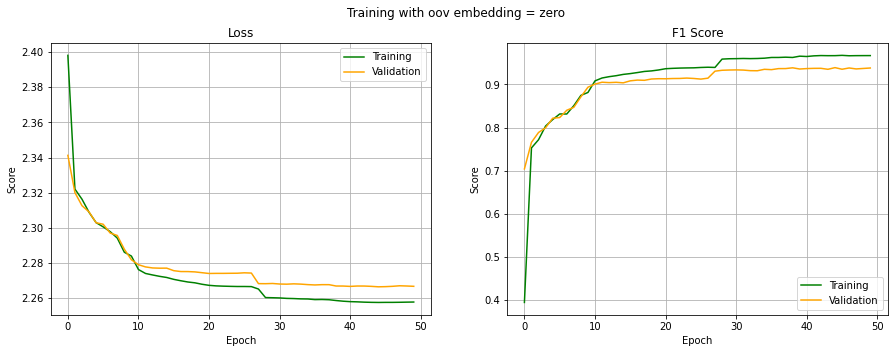

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../logs/zero/fold_{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with oov embedding = zero")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9673, device='cuda:0'),
 tensor(0.9372, device='cuda:0'),
 tensor(0.9383, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9673, device='cuda:0'),
 tensor(0.9372, device='cuda:0'),
 tensor(0.9383, device='cuda:0'))

## Heatmap

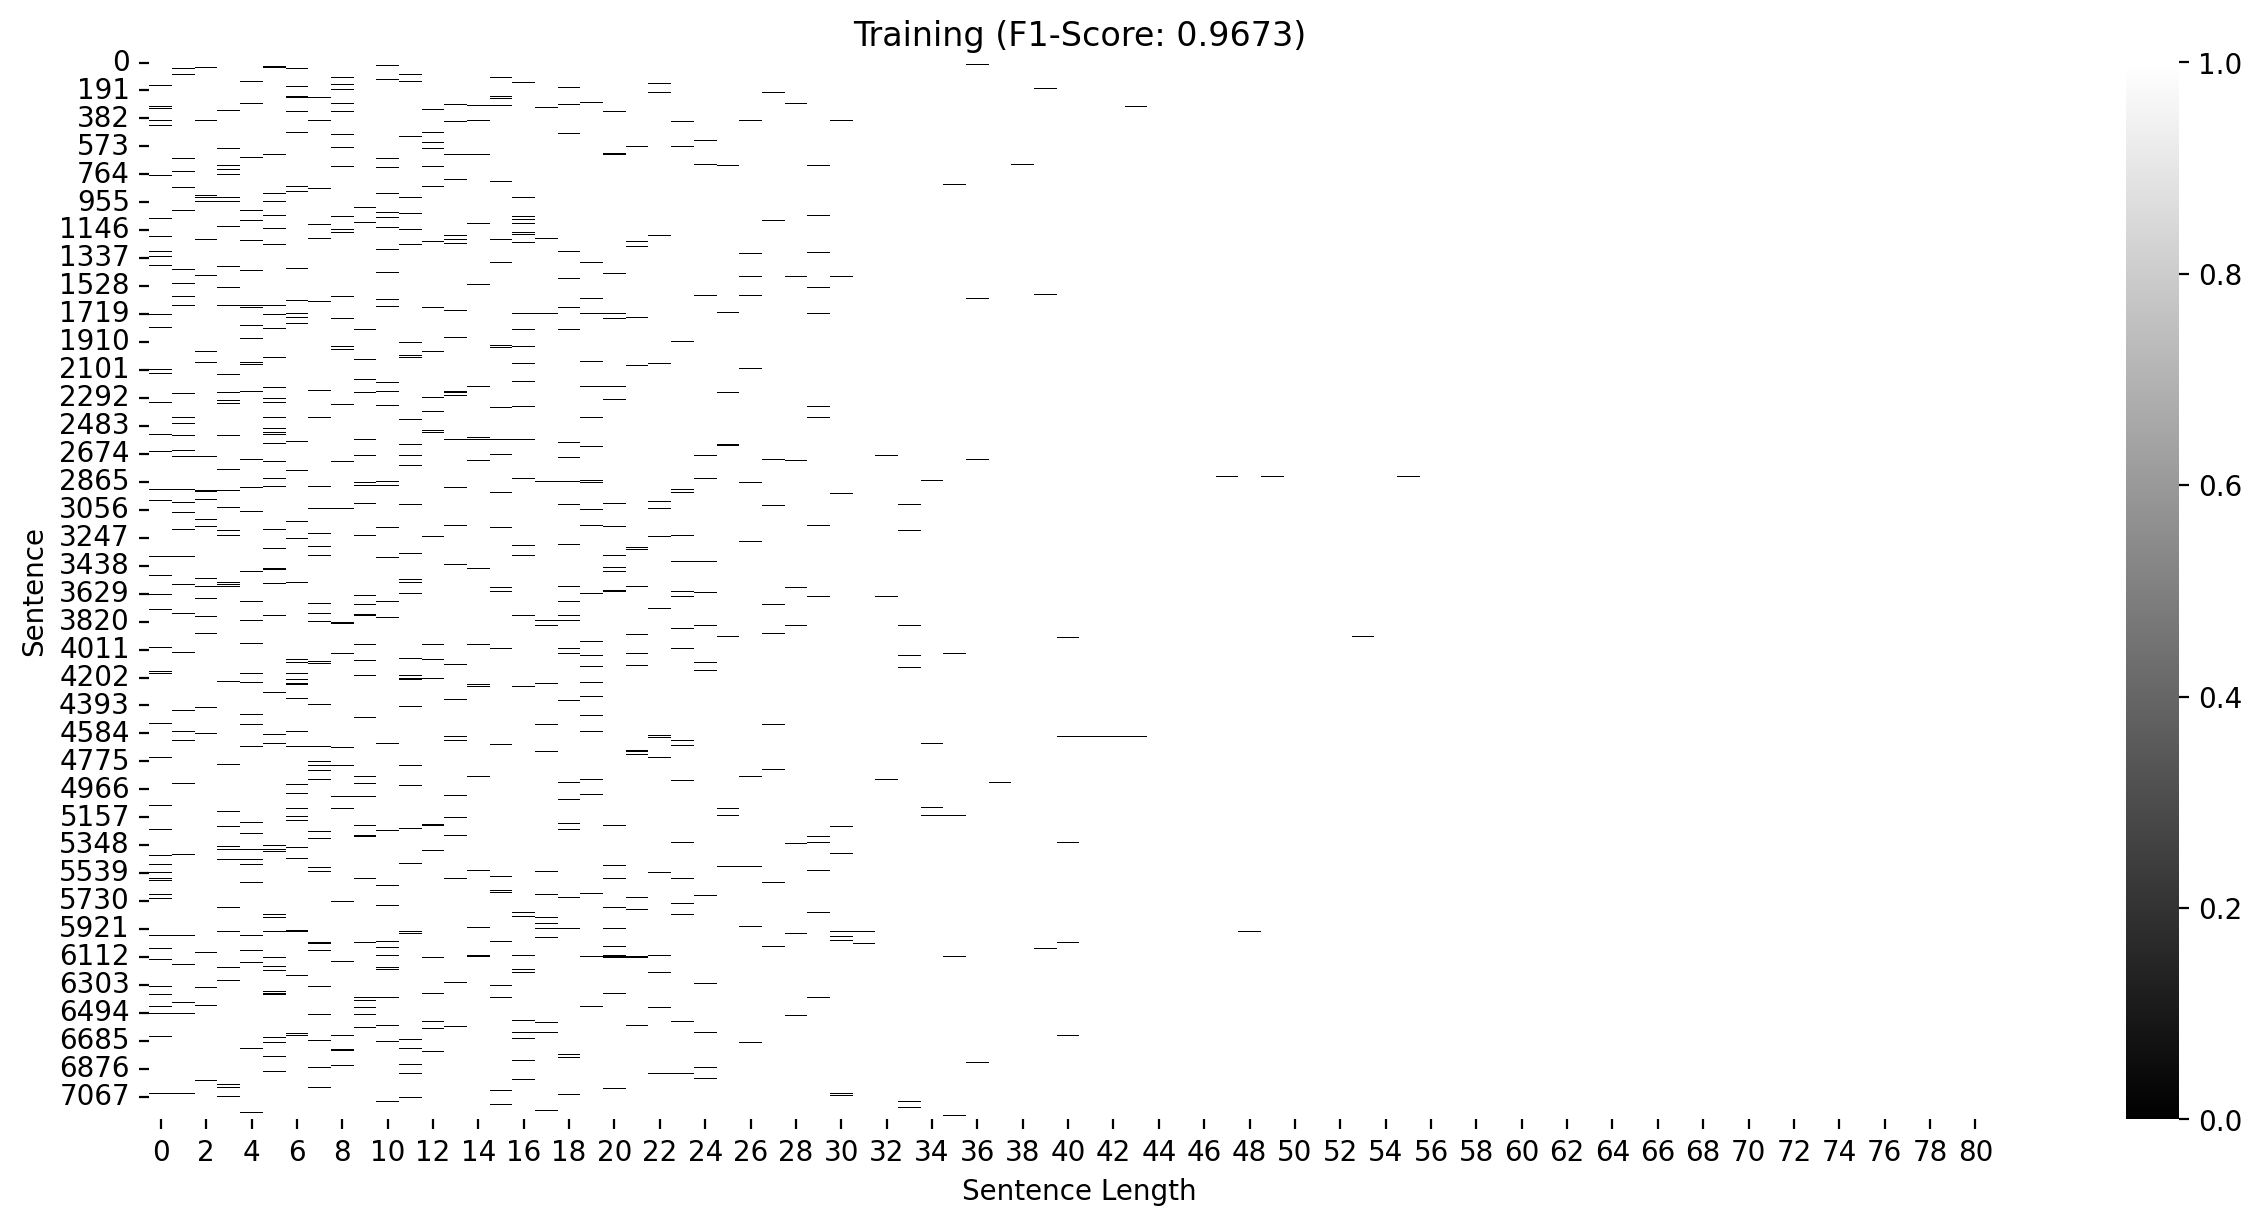

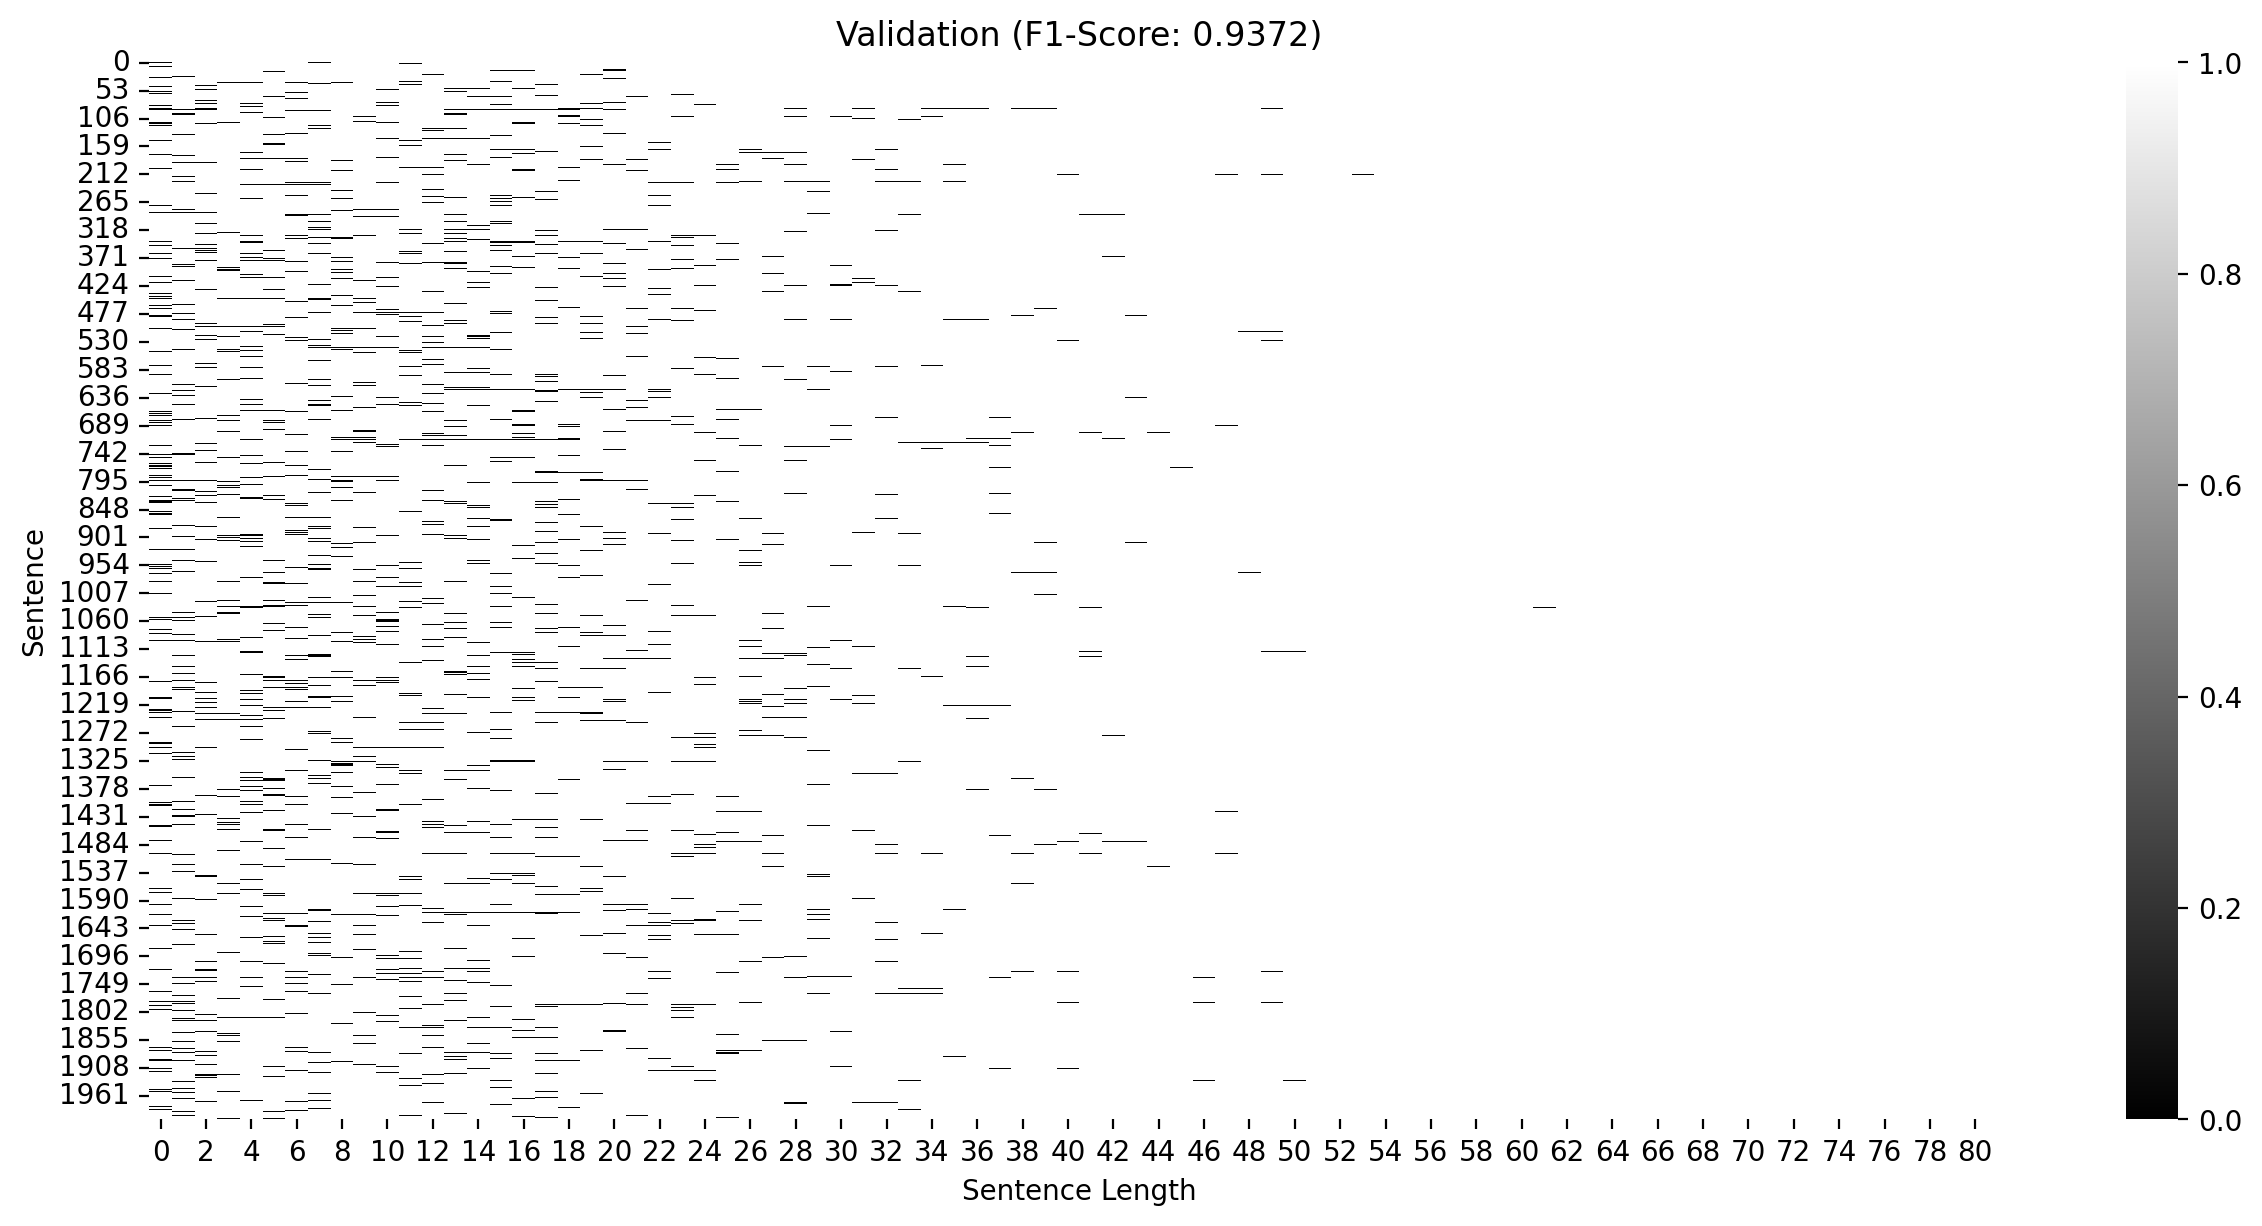

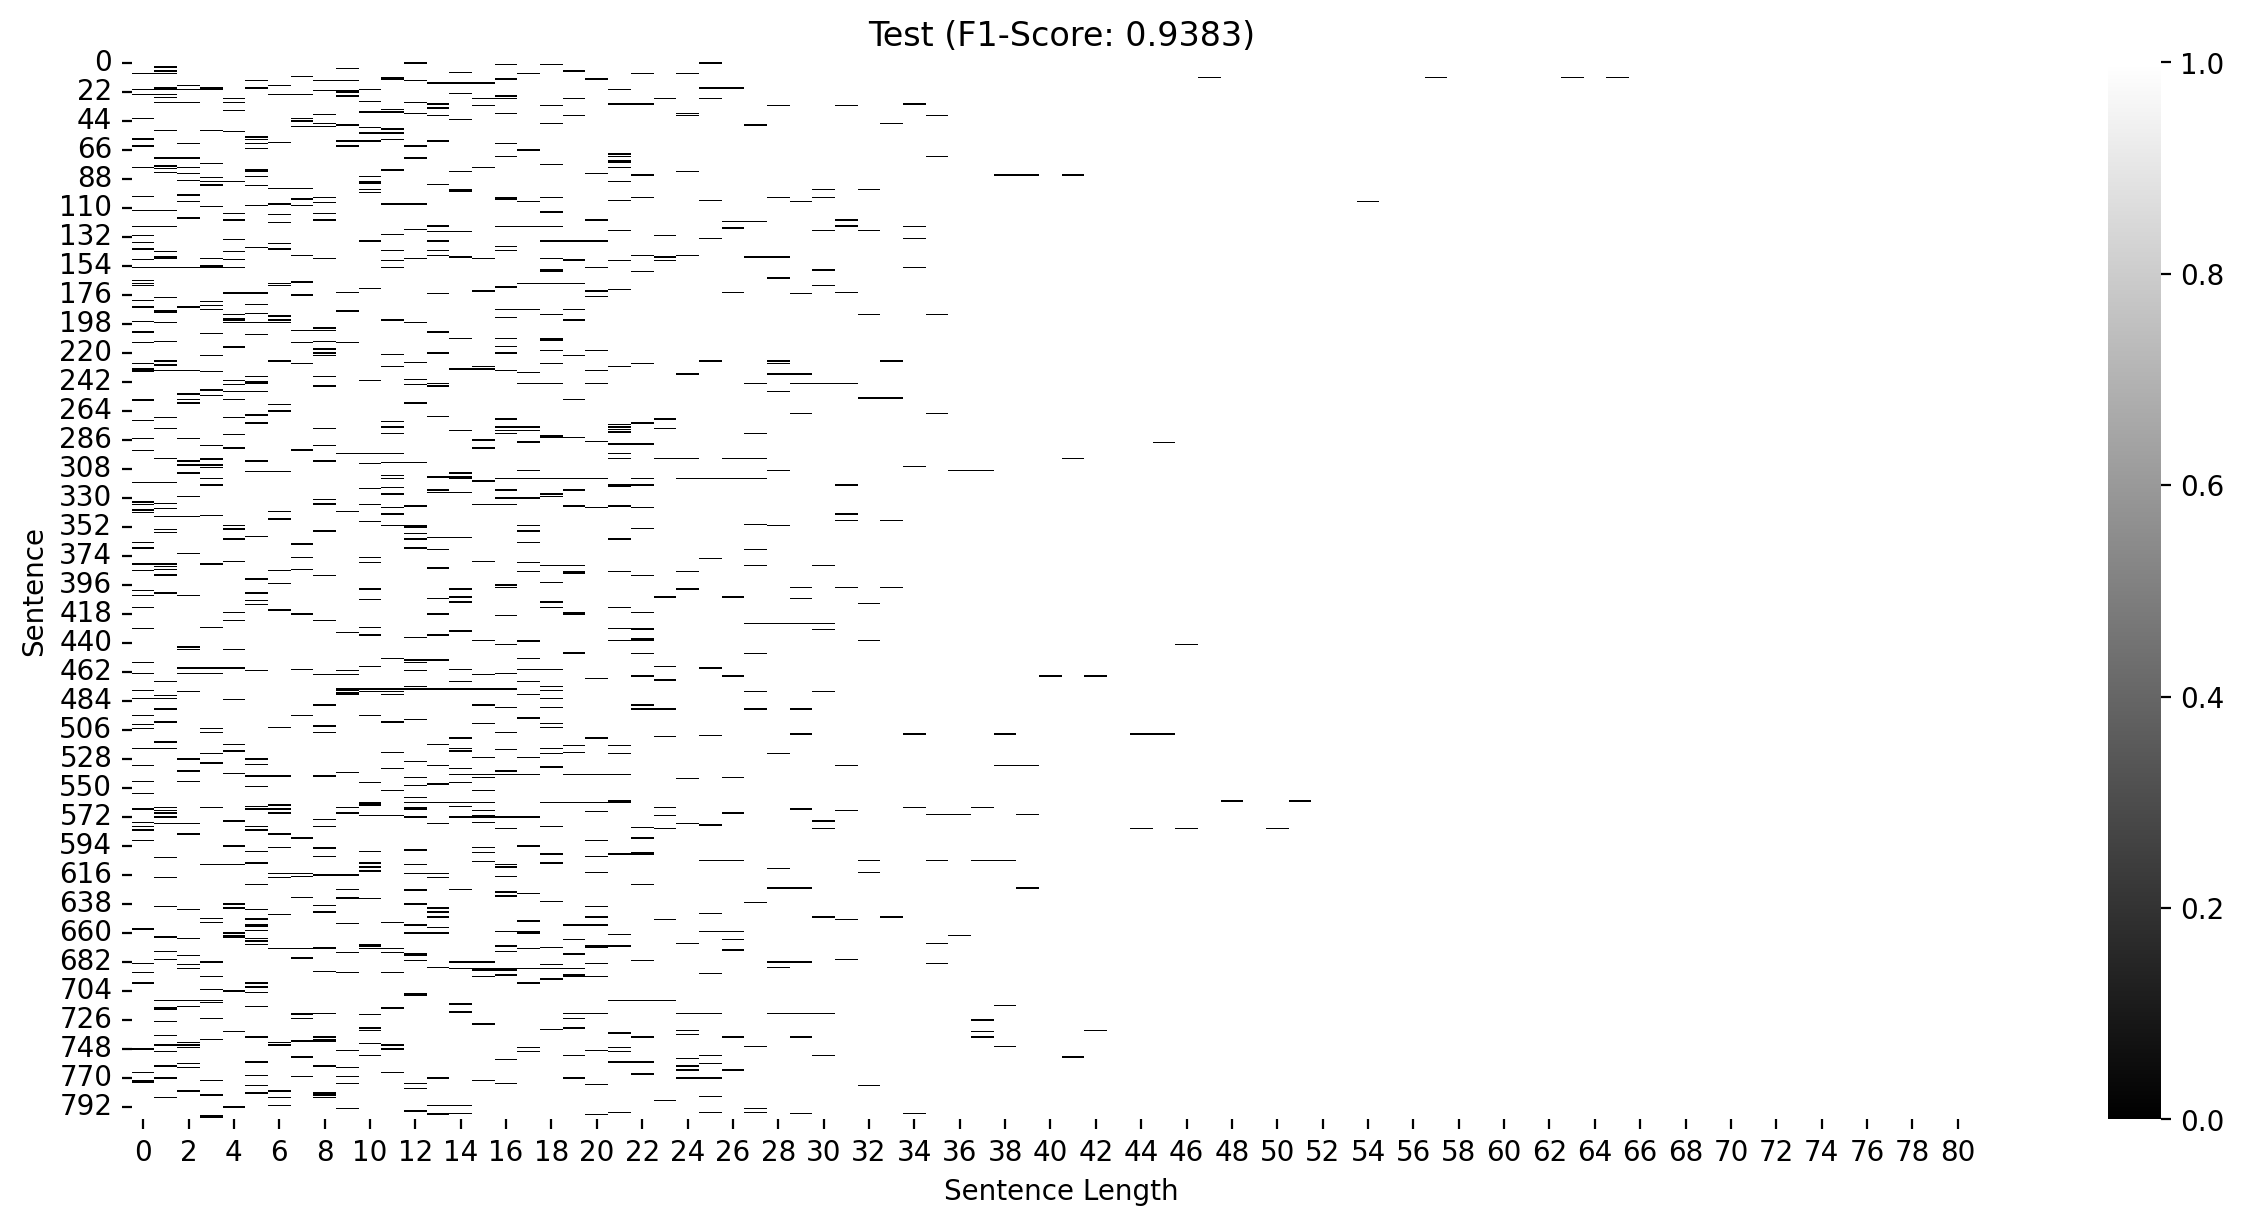

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


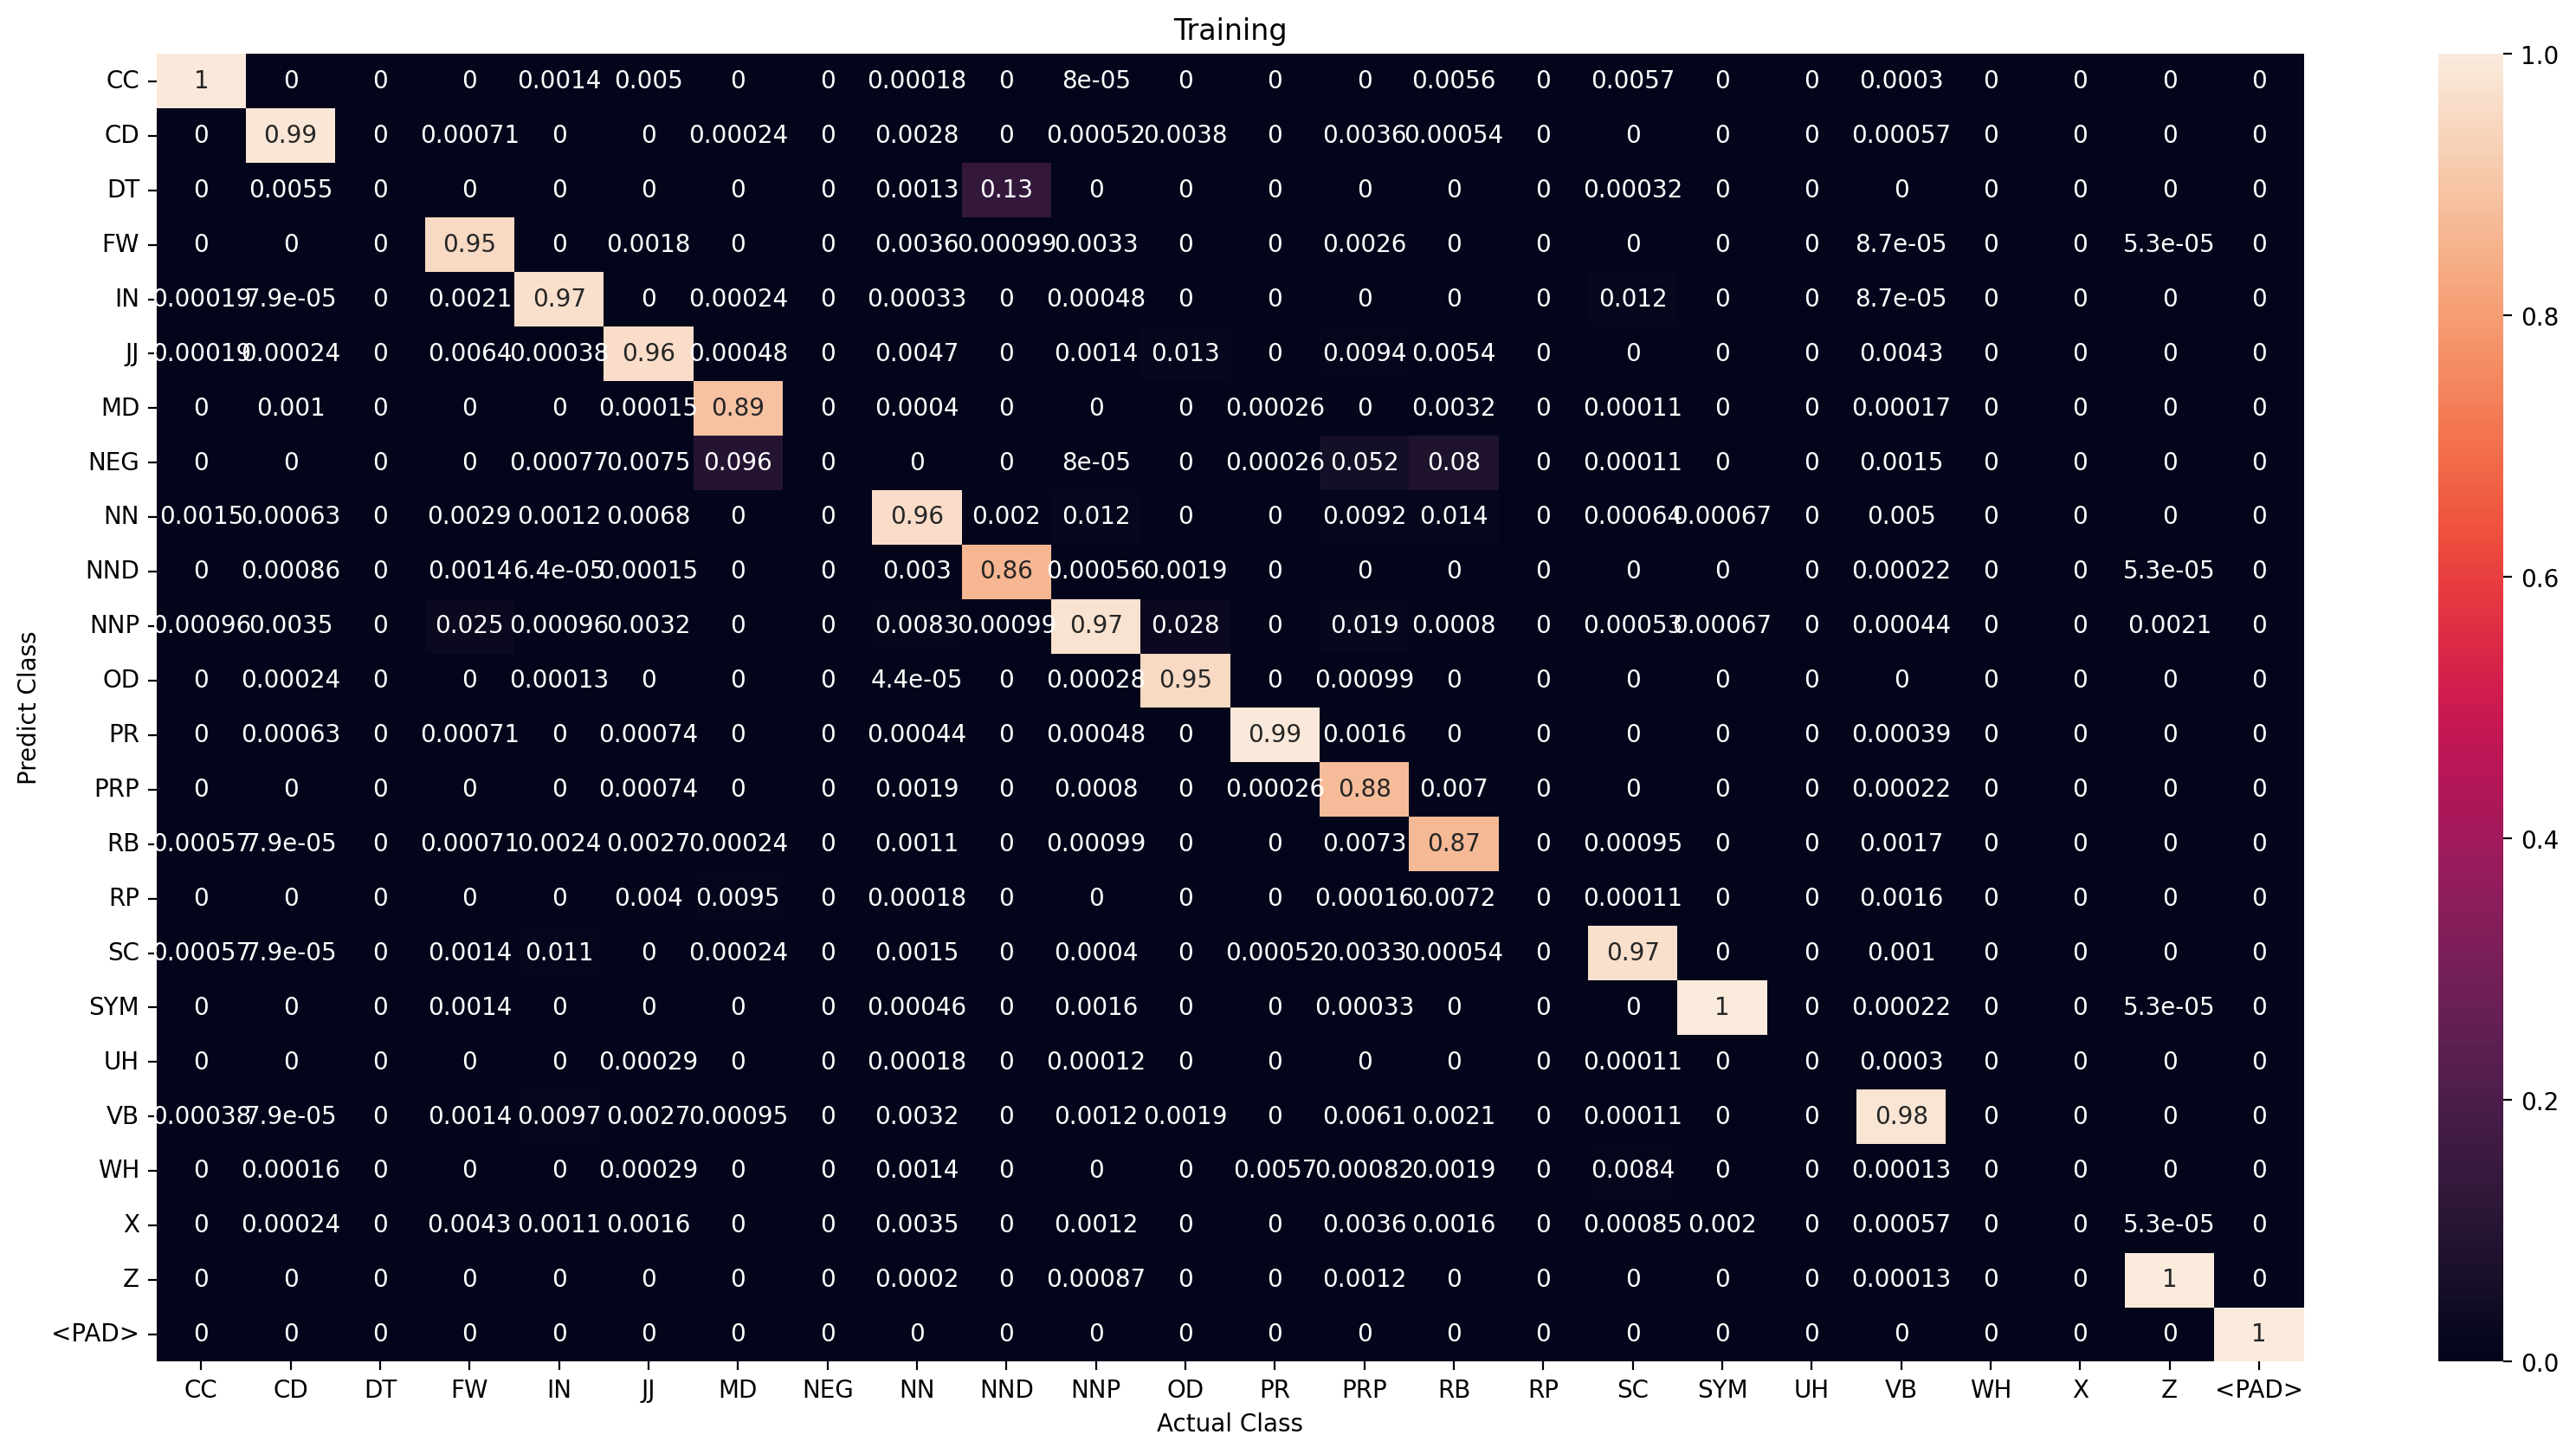

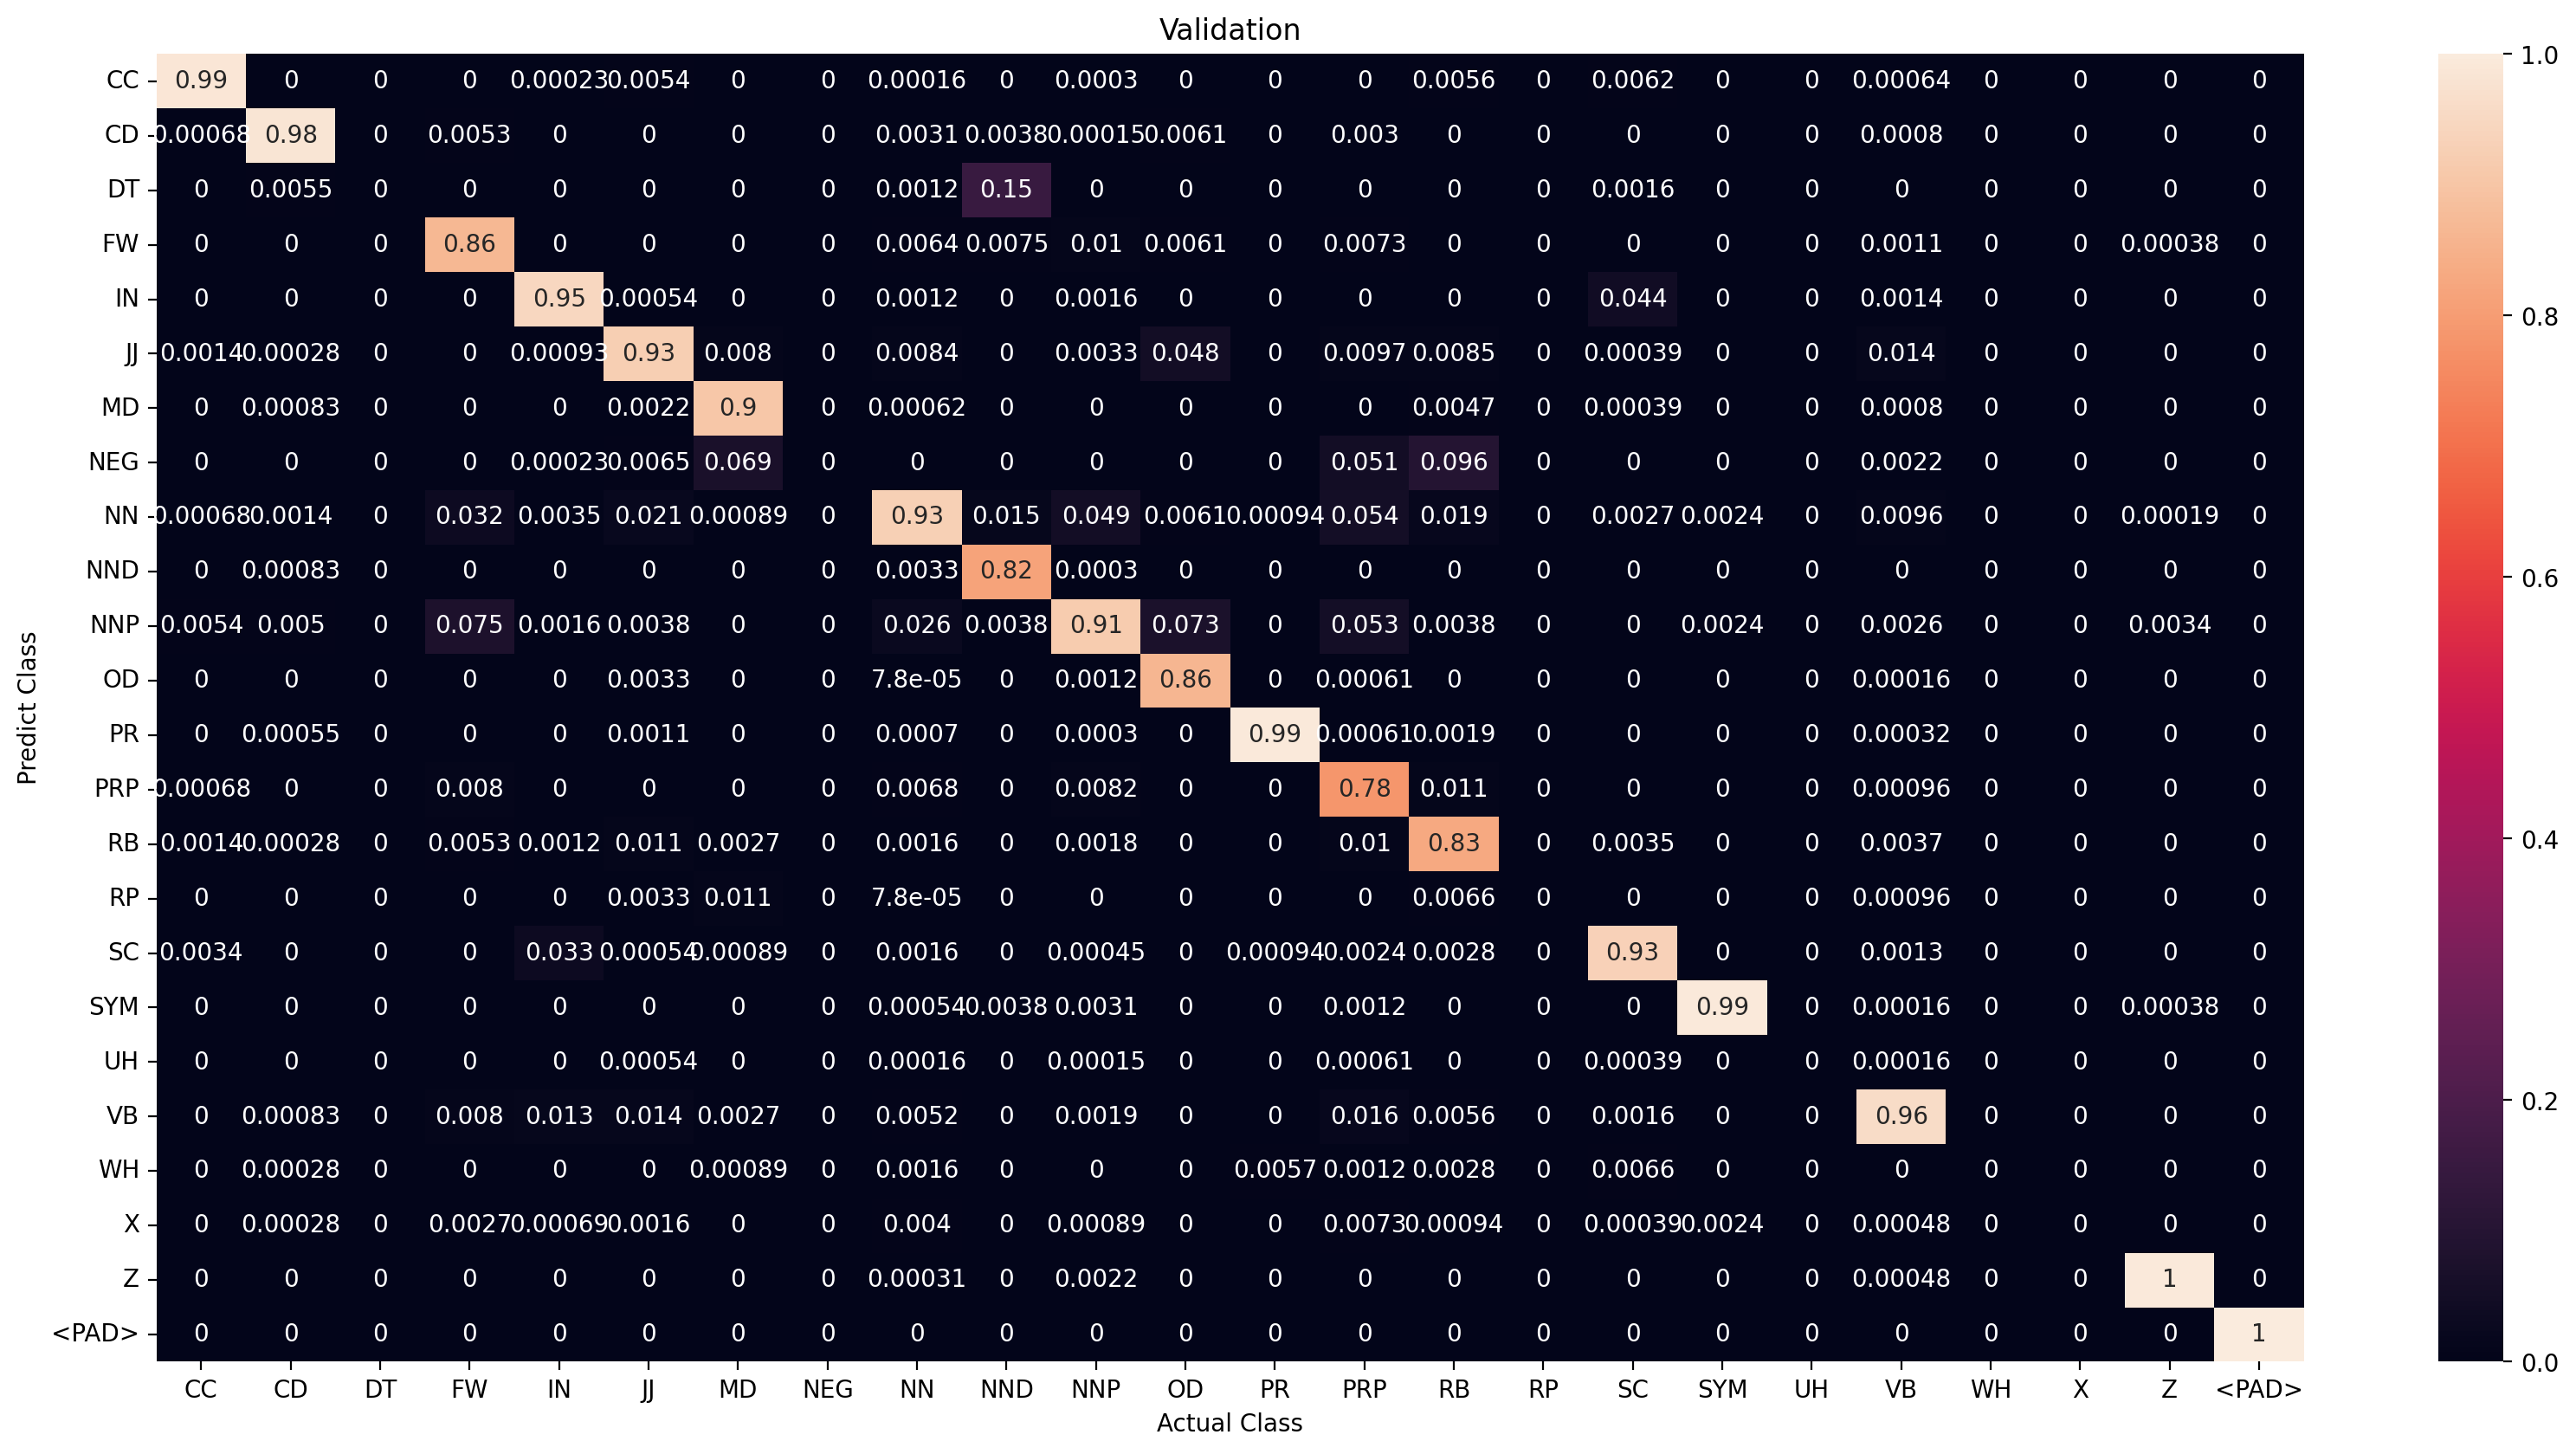

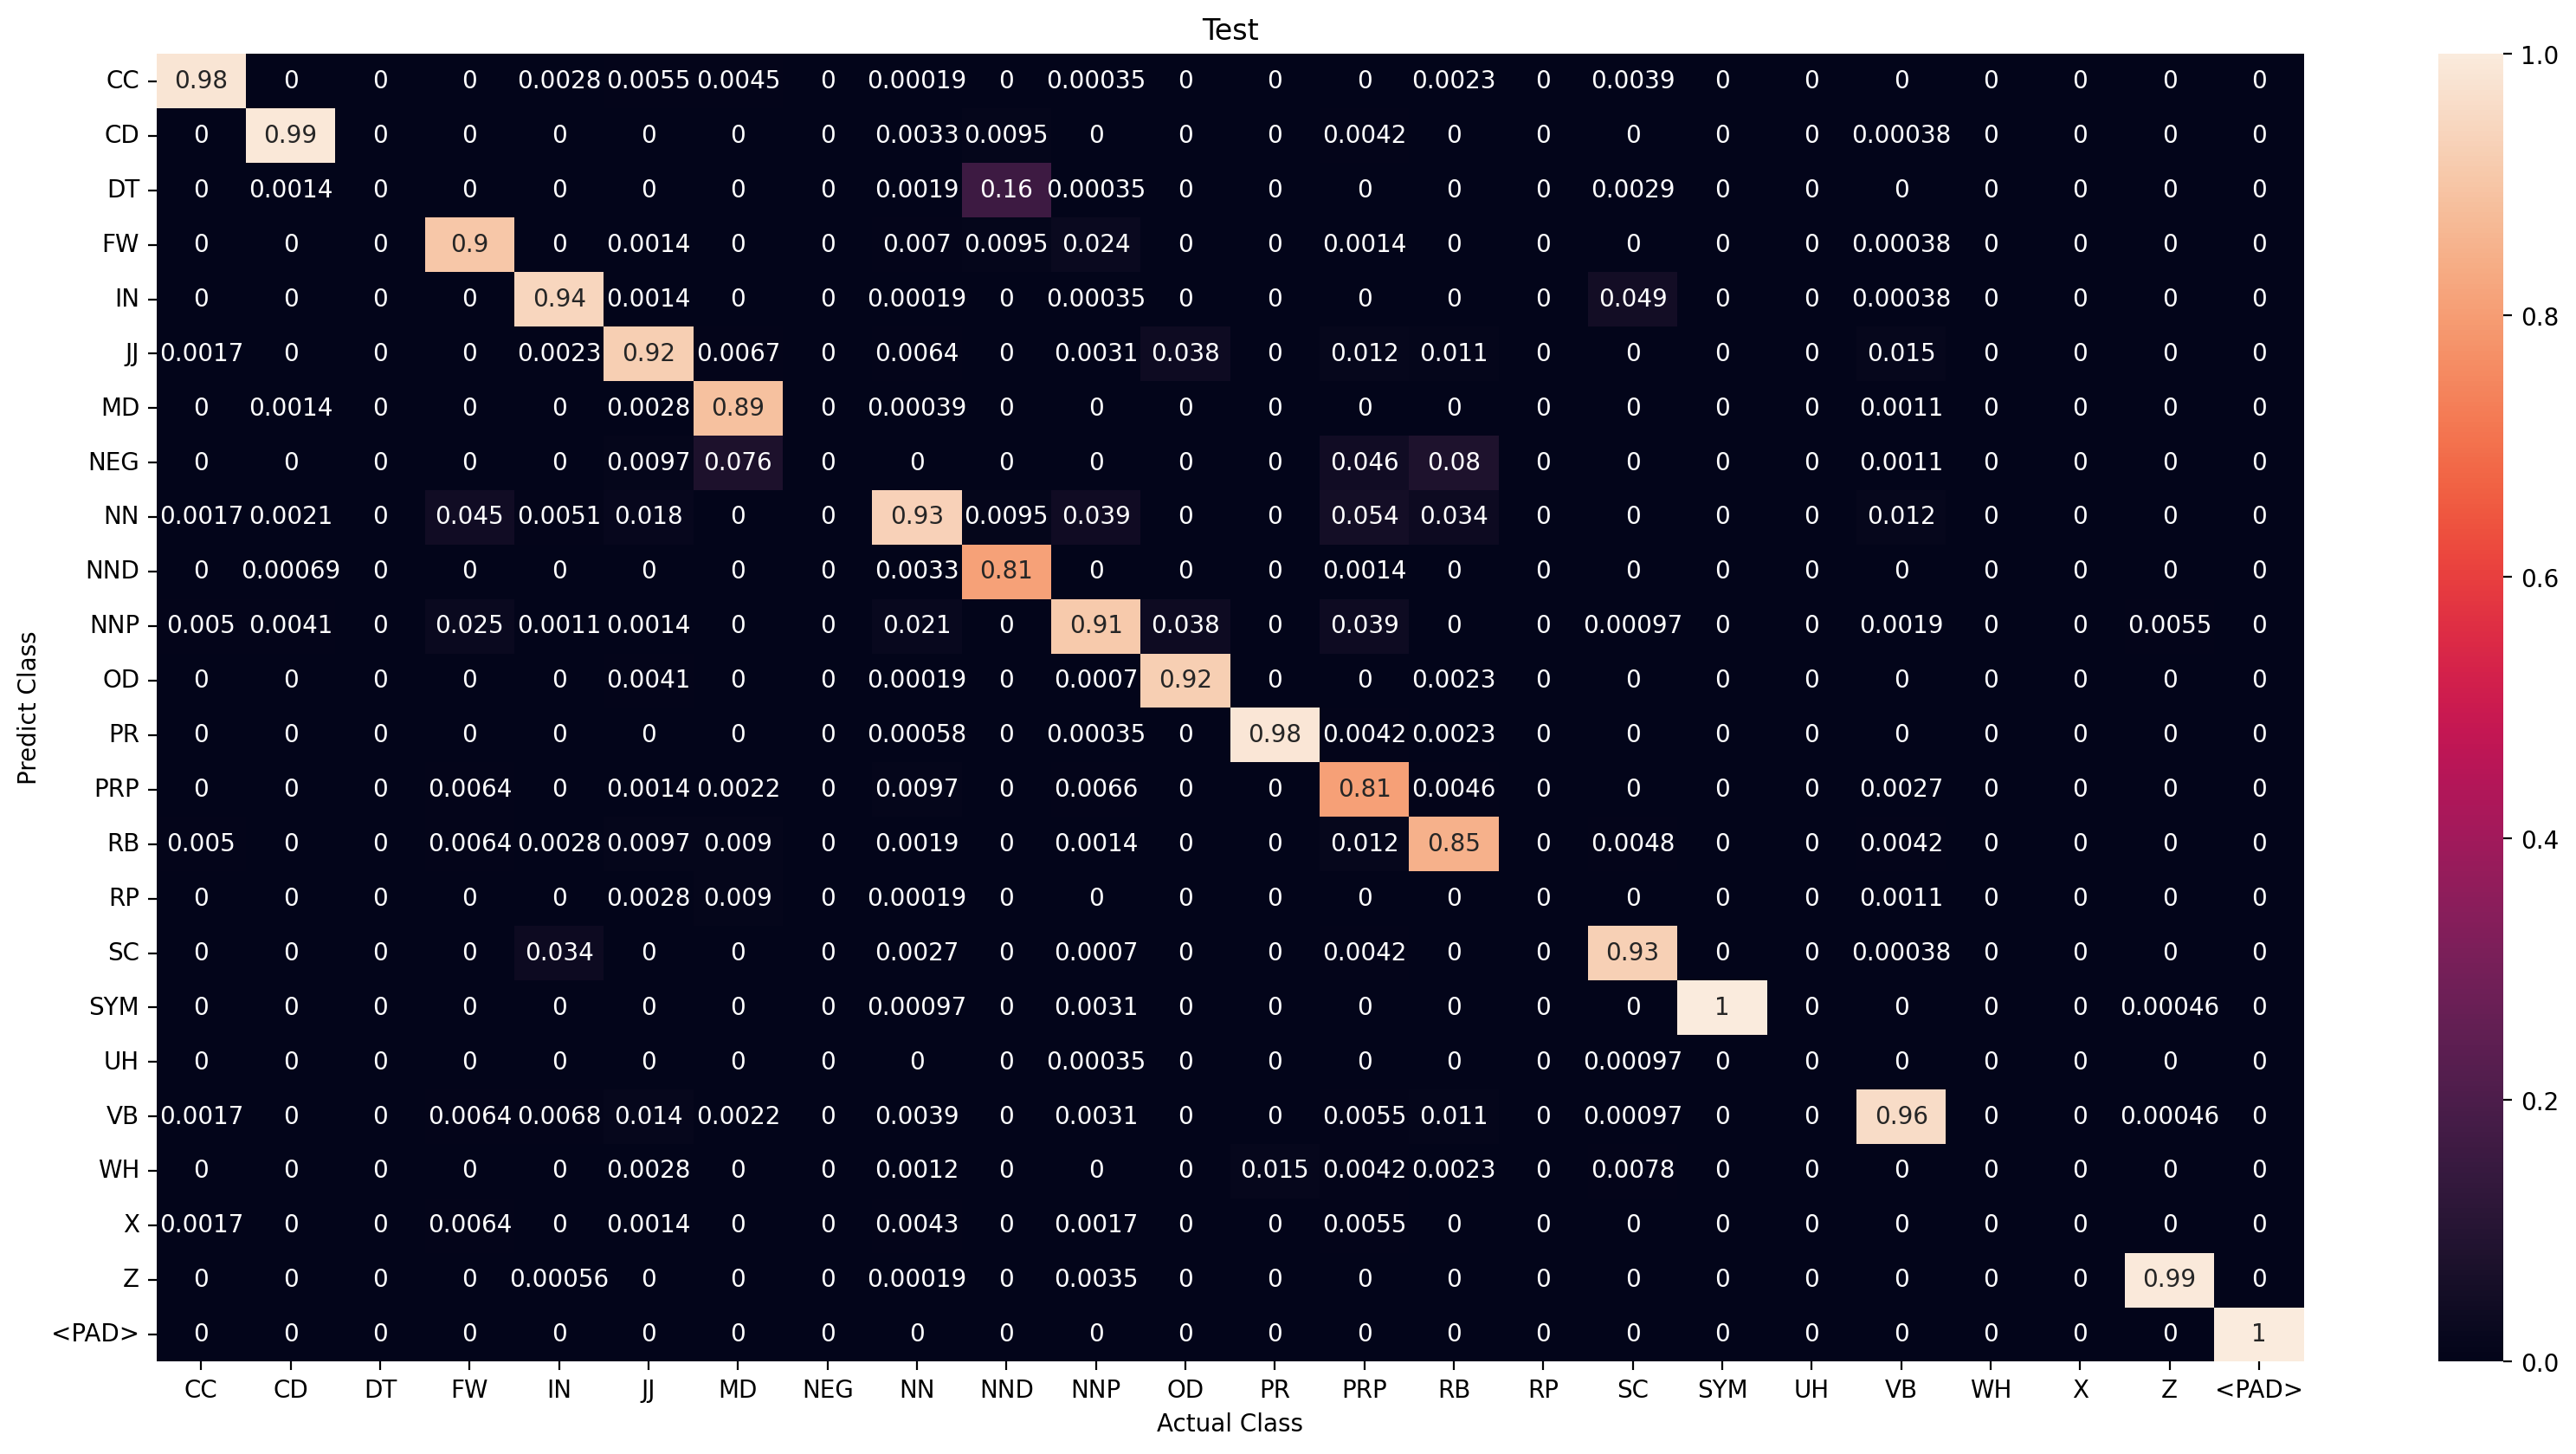

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5198       | CC    : 148      |
| CD    : 12730  | CD    : 12550      | CD    : 180      |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1335       | FW    : 279      |
| IN    : 15342  | IN    : 15194      | IN    : 148      |
| JJ    : 6981   | JJ    : 6528       | JJ    : 453      |
| MD    : 3799   | MD    : 3749       | MD    : 50       |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43743      | NN    : 626      |
| NND   : 1047   | NND   : 875        | NND   : 172      |
| NNP   : 25175  | NNP   : 24481      | NNP   : 694      |
| OD    : 524    | OD    : 504        | OD    : 20       |
| PR    : 3880   | PR    : 3815       | PR    : 65       |
| PRP   : 5471   | PRP   : 5328       | PRP   : 143      |
| RB    : 3477   | RB    : 3247       | RB    : 230      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8, 19, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 10343
Wrong prediction            : 1463
Percentage correct oov pred : 87.6079959342707

Validation
Number OOV token            : 3366
Correct prediction          : 2380
Wrong prediction            : 986
Percentage correct oov pred : 70.70707070707071

Test
Number OOV token            : 1390
Correct prediction          : 1001
Wrong prediction            : 389
Percentage correct oov pred : 72.01438848920864



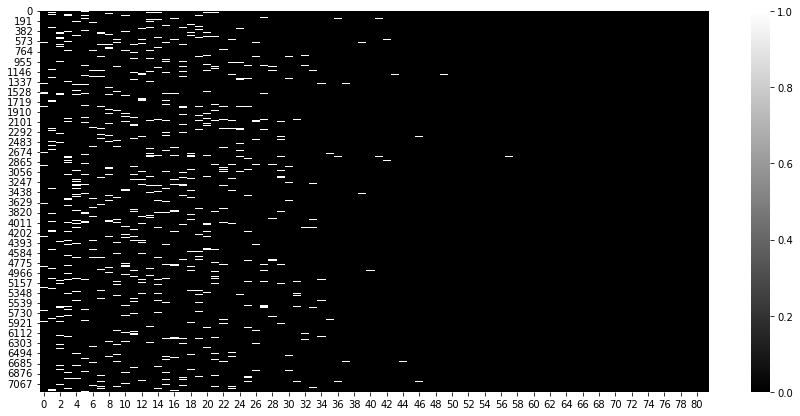

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

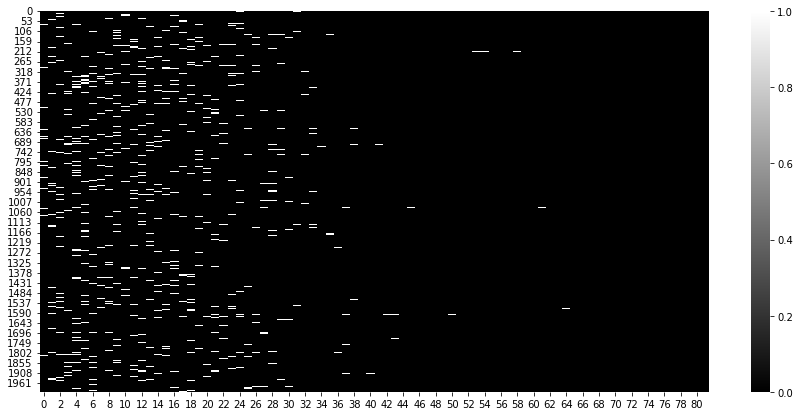

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

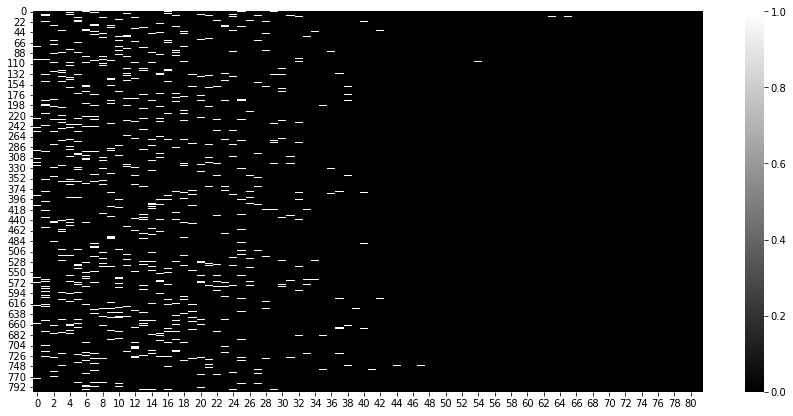

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);